<a href="https://colab.research.google.com/github/y-oth/dst_assessment2/blob/main/FIRST%20STEPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


TO DO THIS, GO ON KAGGLE :https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri

THEN DOWLOAD TO ZIP USINNG THE DOWLOAD BUTTON.

THEN ADD IT TO YOUR GOOGLE DRIVE AS A ZIP FILE.
THEN MYDIRVE/YOUR_NOTEBOOK/DATASET.ZIP


In [3]:
!unzip "/content/drive/MyDrive/Github/Assessment 2/MRI Brain Data.zip" -d "/content/data"



Archive:  /content/drive/MyDrive/Github/Assessment 2/MRI Brain Data.zip
  inflating: /content/data/Testing/glioma_tumor/image(1).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(10).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(100).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(11).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(12).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(13).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(14).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(15).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(16).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(17).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(18).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(19).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(2).jpg  
  inflating: /content/data/Testing/glioma_tumor/image(20).jpg  
  inflating: /content/data/Testin

In [4]:
!ls /content/data


Testing  Training


Loaded image: /content/data/Training/no_tumor/image (32).jpg


(np.float64(-0.5), np.float64(469.5), np.float64(507.5), np.float64(-0.5))

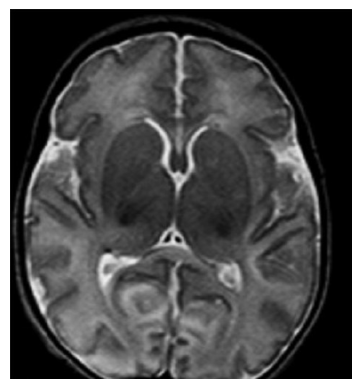

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt

root = "/content/data/Training"

# Find the first image in the training folder
image_path = None
for subdir, dirs, files in os.walk(root):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(subdir, file)
            break
    if image_path:
        break

print("Loaded image:", image_path)

img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")


In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder("/content/data/Training", transform=transform)
test_dataset  = datasets.ImageFolder("/content/data/Testing",  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [9]:
train_dataset.classes


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [10]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)


torch.Size([32, 3, 224, 224]) torch.Size([32])


(np.float64(-0.5), np.float64(1809.5), np.float64(453.5), np.float64(-0.5))

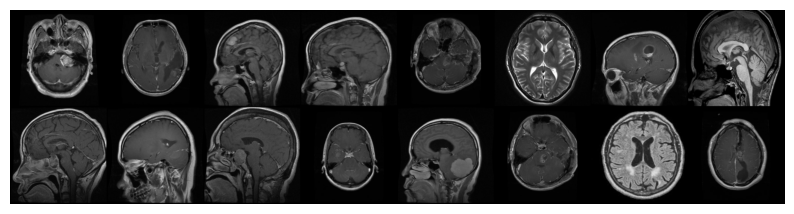

In [11]:
import matplotlib.pyplot as plt
import torchvision

plt.figure(figsize=(10,10))
plt.imshow(torchvision.utils.make_grid(images[:16]).permute(1,2,0))
plt.axis("off")


In [12]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 64),
            nn.ReLU(),
            nn.Linear(64, len(train_dataset.classes)),
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)


In [13]:
import torchvision.models as models
import torch.nn as nn

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 92.4MB/s]


In [14]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Using device: cpu


In [ ]:
epochs = 5  # increase later

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = correct / total * 100
    print(f"Epoch [{epoch+1}/{epochs}]  Loss: {running_loss:.4f}  Train Acc: {train_acc:.2f}%")


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total * 100
print("Test Accuracy:", test_acc)
